In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
from sklearn.decomposition import PCA

plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (12 , 12)
plt.style.use('dark_background')

In [3]:
import tensorflow as tf

In [ ]:
#embedding layer imports:
import gensim.downloader
import gensim
glove = gensim.downloader.load('glove-twitter-25')2

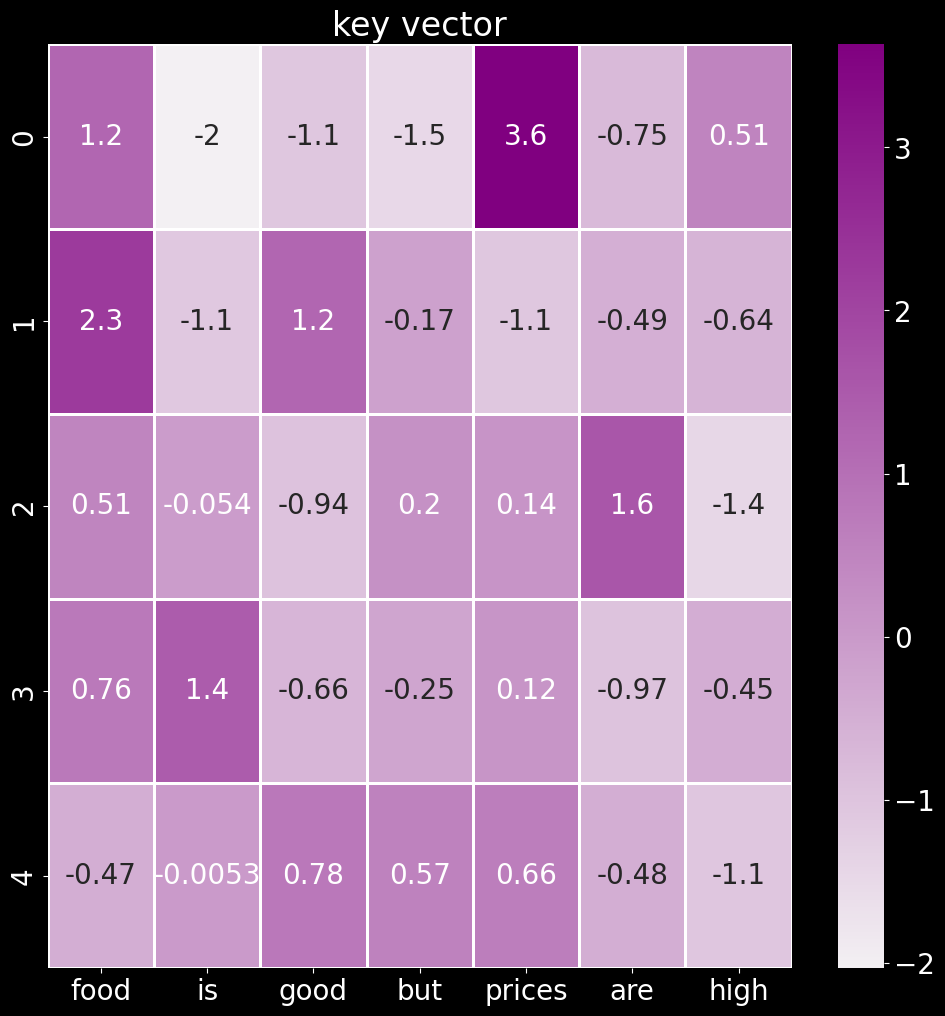

In [ ]:
text = 'food is good, but prices are high.'
text = text.translate(text.maketrans('' , '' , string.punctuation))

words = text.split()

# 1. create key

pca = PCA(n_components= 5)
tokens = [glove[word].tolist() for word in words]
key = pca.fit_transform(tokens)

kdf = pd.DataFrame(np.matrix(key).transpose() , columns = words)
sns.heatmap(kdf , annot = True ,  cmap = sns.light_palette('purple' , as_cmap = True) , linewidths = 1).set_title('key vector')
plt.show()

In [6]:
value = key
vdf = pd.DataFrame(value.T , columns = words)
vdf

,food,is,good,but,prices,are,high
0,1.198695,-2.034884,-1.077090,-1.481084,3.632923,-0.752410,0.513852
1,2.255404,-1.100909,1.224496,-0.170320,-1.079529,-0.493519,-0.635622
2,0.505580,-0.054347,-0.938212,0.204491,0.138739,1.581181,-1.437432
3,0.763951,1.443557,-0.660844,-0.249058,0.121044,-0.971596,-0.447054
4,-0.467900,-0.005251,0.778766,0.569702,0.664370,-0.481991,-1.057695


(1, 25)


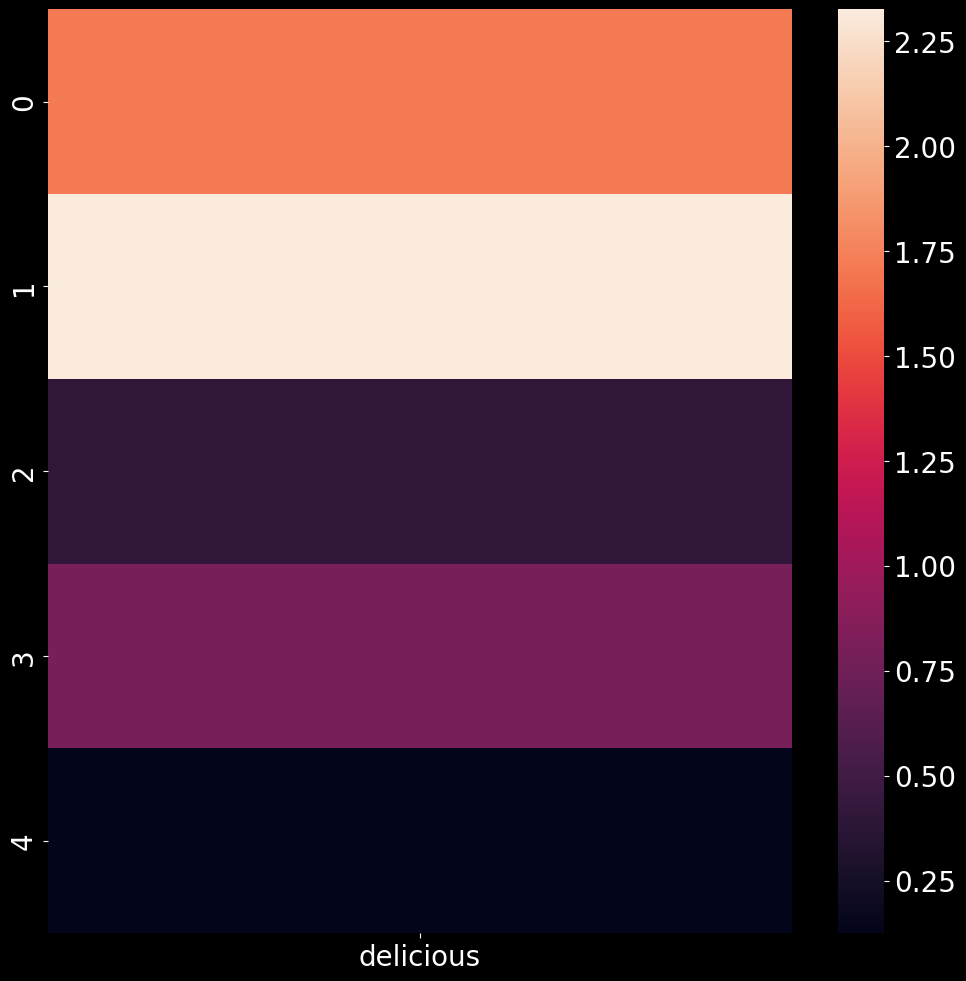

In [90]:
qtext = 'delicious'
query = glove[qtext].reshape(1 , -1)
print(f"{query.shape}")
query = pca.transform(query)
qdf = pd.DataFrame(query.T , columns = [qtext])
sns.heatmap(qdf)
plt.show()

In [91]:
key.shape , query.shape

((7, 5), (1, 5))

Attention score: [[ 8.04485316 -4.92070242  0.20005962 -2.97071036  3.93462642 -2.61948863
  -1.66863778]]
Activated Attention Score: [[9.83382362e-01 2.30066385e-06 3.85275921e-04 1.61705191e-05
  1.61314579e-02 2.29751112e-05 5.94575345e-05]]


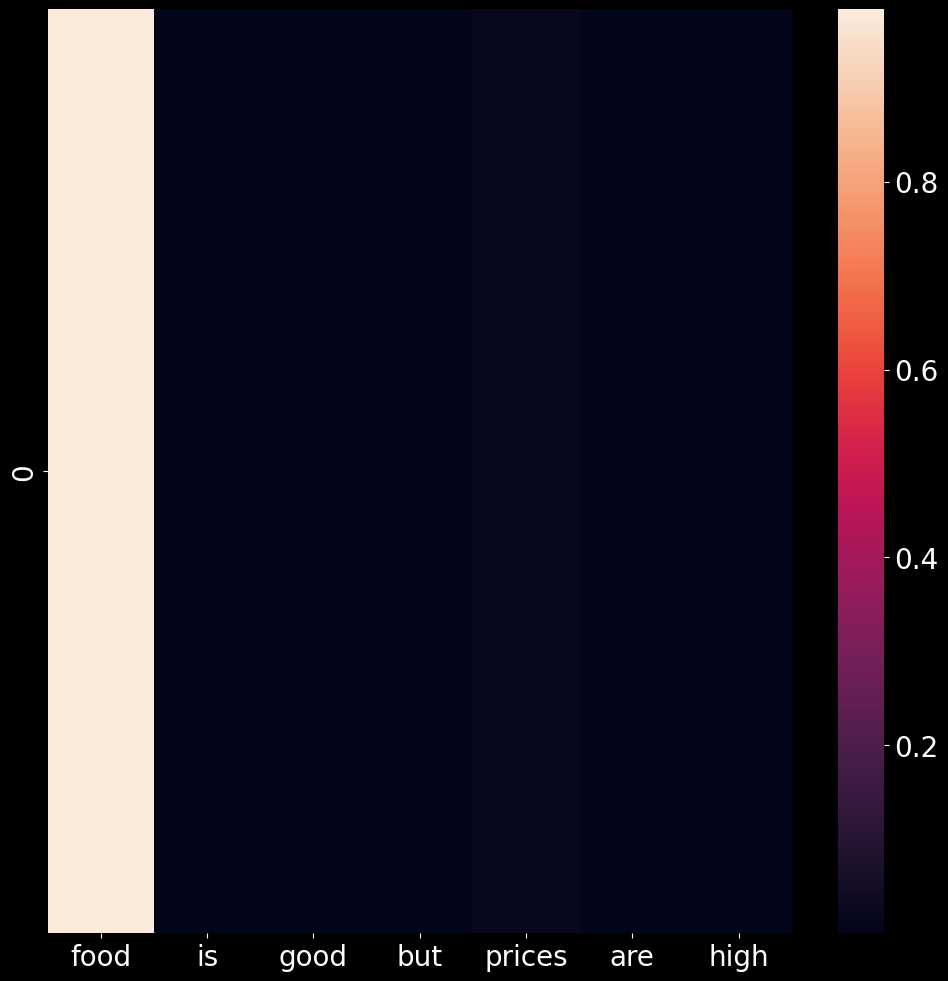

In [ ]:
attention_score = query @ key.T
print(f"Attention score: {attention_score}")

activated_attention_score = tf.nn.softmax(attention_score)
print(f"Activated Attention Score: {activated_attention_score}")
aadf = pd.DataFrame(activated_attention_score , columns = words)
# aadf.head()
sns.heatmap(aadf)
plt.show()
# activated_attention_score.shape , value.shape


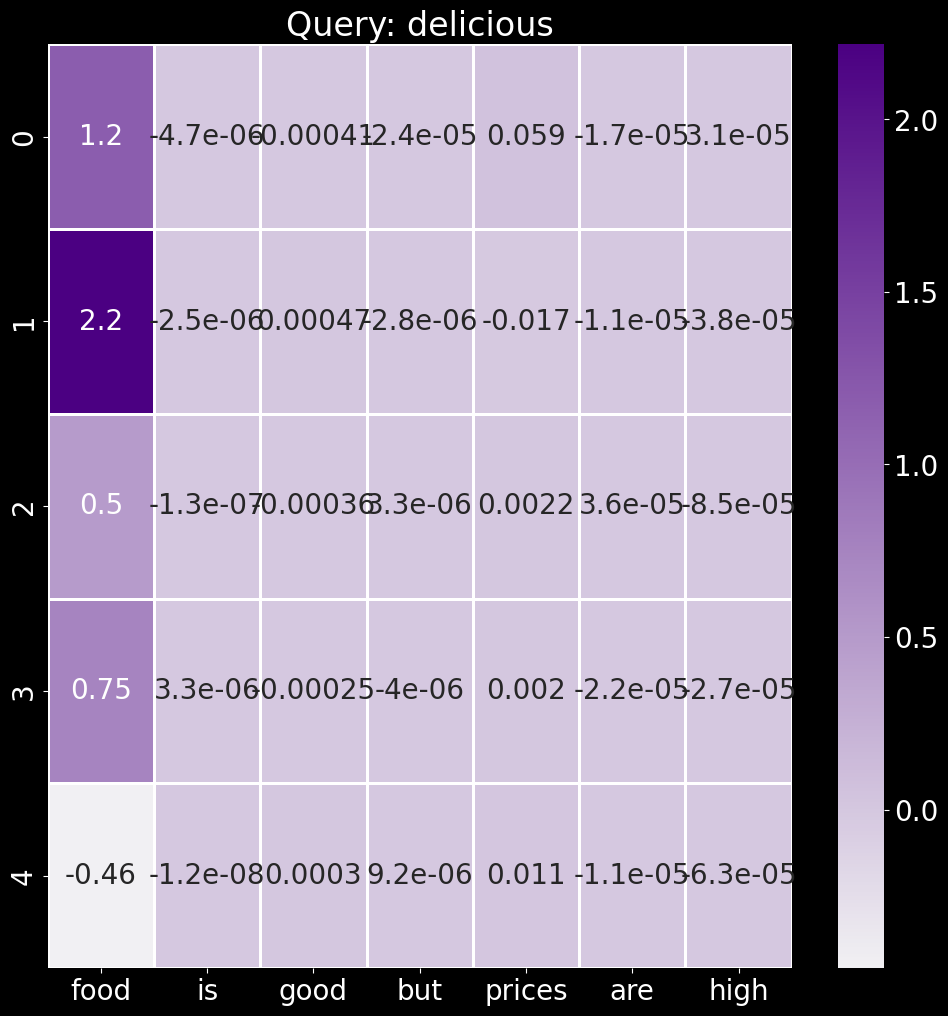

In [122]:
def finalAttention(aweights , value):
    return np.array([value.T[: , i] * aweights[0 , i] for i in range(activated_attention_score.shape[1])])

fattention = finalAttention(activated_attention_score , value)
fdf = pd.DataFrame(fattention.T , columns = words)
fdf.head()
sns.heatmap(fdf , annot = True , cmap = sns.light_palette('indigo' , as_cmap = True) , linewidths= 1).set_title(f'Query: {qtext}')
plt.show()

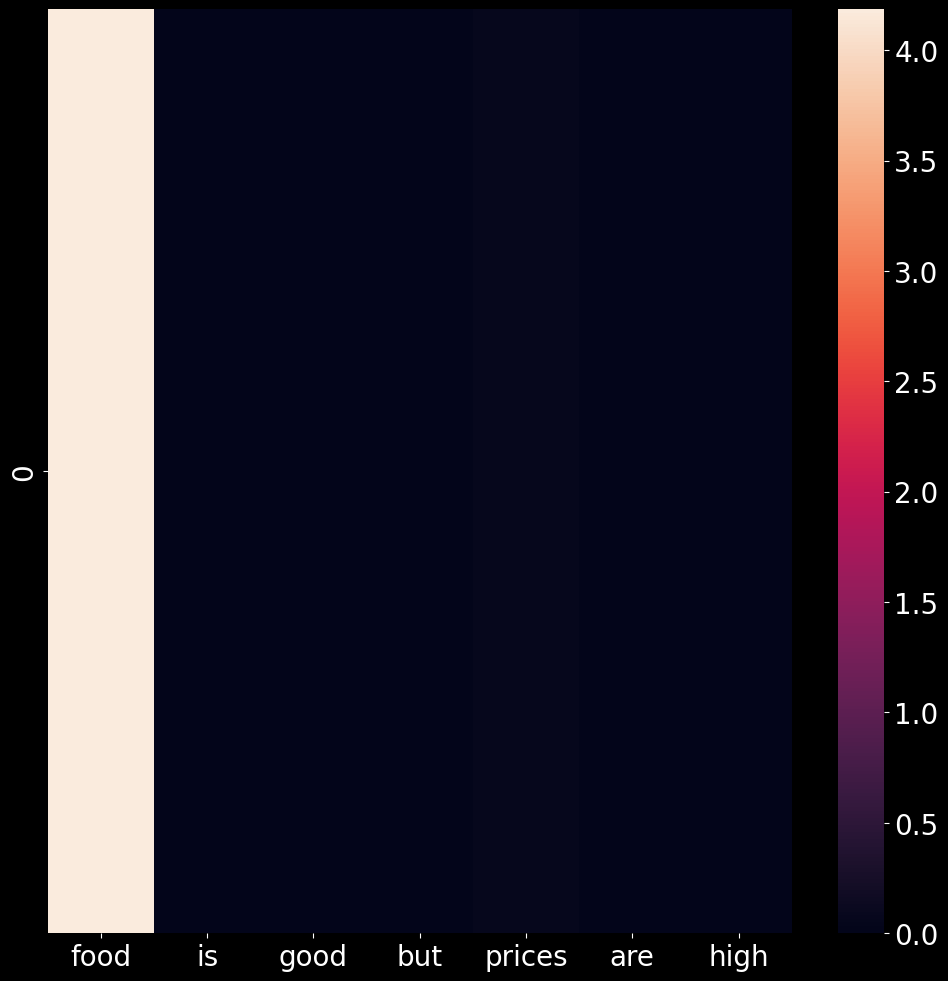

In [130]:
fcontext = pd.DataFrame(fattention.sum(axis = 1).reshape(1 , -1) , columns = words)
sns.heatmap(fcontext)
plt.show()

In [116]:
activated_attention_score.shape , np.array(fattention).sum(axis = 1).reshape(1 , -1).shape

(TensorShape([1, 7]), (1, 7))

In [120]:
np.arange(100).reshape(5 , 20).sum(axis = 1).shape

(5,)

## multi-head self attention:


In [247]:
# multi head self attention:
paragraph = ['food quality was not good as it was not cooked properly.']
paragraph = [[word.translate(word.maketrans('' , '' , string.punctuation)) for word in text.split()] for text in paragraph]
print(f'{paragraph}')
target = paragraph

# create word embeddings for key text:
x = np.array([[glove[word] for word in text] for text in paragraph])
x = np.array([pca.transform(sent) for sent in x]).squeeze()

# create word embeddings for query text
y = np.array([[glove[word] for word in text] for text in target])
y = np.array([pca.transform(sent) for sent in y]).squeeze()

[['food', 'quality', 'was', 'not', 'good', 'as', 'it', 'was', 'not', 'cooked', 'properly']]


In [275]:
#initialize weight matrices:
wk = np.random.random((5 , 9))
wq = np.random.random((5 , 9))
wv = np.random.random((5 , 9))

nhead = 3

#compute vectors:

kvec = np.matmul(x , wk)
qvec = np.matmul(x , wq)
vvec = np.matmul(x , wv)


#compute attention vector:

amat = np.matmul(qvec , kvec.T)
amat = tf.nn.softmax(amat , axis = 0)

kmat = np.array(np.hsplit(kvec , nhead))
# np.concatenate(kmat , axis = 1).shape
qmat = np.array(np.hsplit(qvec , nhead))
vmat = np.array(np.hsplit(vvec , nhead))


z = []
for head in range(nhead):
    amat = np.matmul(qmat[head] , kmat[head].T) / (5)**0.5

    amatexp = np.exp(amat)
    amat = amatexp / amatexp.sum(axis = 0)

    cvec = np.matmul(amat , vmat[head])
    z.append(cvec)


context_vector = np.hstack(z)           #multi-head attention context vector.